In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import xarray as xr
from joblib import load
import matplotlib.pyplot as plt
import datetime

data_path = Path.home()/'OneDrive'/'Kirstin'/'Uni'/'Year4'/'MSciProject'/'data_files'

#### Functions

In [3]:
def read_manning(site):
    """Read Alistair's baseline flags for a given site

    Args:
        site (str): Site code (e.g., MHD)

    Returns:
        pandas.DataFrame: DataFrame with baseline flags (binary)
    """
    
    site_translator = {"MHD": "MH"}

    # Filtering so only including data relevant to the given site
    files = (data_path / "manning_baselines").glob(f"{site_translator[site]}*.txt")

    dfs = []

    # Looping through each of the files for the given site
    for file in files:

        # Read the data, skipping metadata, putting into pandas dataframe
        data = pd.read_csv(file, skiprows=6, delim_whitespace=True)

        # Setting the index of the dataframe to be the extracted datetime and naming it time
        data.index = pd.to_datetime(data['YY'].astype(str) + "-" + \
                                    data['MM'].astype(str) + "-" + \
                                    data['DD'].astype(str) + " " + \
                                    data['HH'].astype(str) + ":00:00")

        data.index.name = "time"
        
        # Adding the 'Ct' column to the previously created empty list
        dfs.append(data[["Ct"]])
    
    # Creating a dataframe from the list containing all the 'Ct' values
    df = pd.concat(dfs)

    df.sort_index(inplace=True)
    
    # Replace all values in Ct column less than 10 or greater than 20 with 0
    # not baseline values
    df.loc[(df['Ct'] < 10) | (df['Ct'] >= 20), 'Ct'] = 0

    # Replace all values between 10 and 19 with 1
    # baseline values
    df.loc[(df['Ct'] >= 10) & (df['Ct'] < 20), 'Ct'] = 1

    # Rename Ct column to "baseline"
    df.rename(columns={'Ct': 'baseline'}, inplace=True)

    return df

In [10]:
# BALANCING THE DATASET BY RANDOMLY UNDERSAMPLING NON-BASELINE DATA POINTS
def balance_baselines(ds):   
    # counting number of baseline&non-baseline data points
    baseline_count = ds['baseline'].where(ds['baseline']==1).count()
    non_baseline_count = ds['baseline'].where(ds['baseline']==0).count()

    # finding the minimum number - expected to be baseline
    min_count = int(min(baseline_count, non_baseline_count))

    # randomly undersampling non-baseline
    np.random.seed(42)
    undersampled_non_baseline = ds.where(ds['baseline'] == 0, drop=True)
    undersampled_non_baseline = undersampled_non_baseline.isel(time=np.random.choice(undersampled_non_baseline.dims['time'], min_count, replace=False))

    # combining the the undersampled non-baseline with the baseline values
    balanced_ds = xr.merge([ds.where(ds['baseline'] == 1), undersampled_non_baseline])
    balanced_ds = balanced_ds.sortby('time')

    # checking balance
    new_baseline_count = balanced_ds['baseline'].where(balanced_ds['baseline']==1).count()
    new_non_baseline_count = balanced_ds['baseline'].where(balanced_ds['baseline']==0).count()

    if(new_baseline_count == new_non_baseline_count):
        return balanced_ds
    else:
        raise ValueError("The counts of baseline and non-baseline values are not equal.")

#### Mace Head

In [11]:
site = "MHD"
df = read_manning(site)

ds_flags = df.to_xarray()
balanced_ds_flags = balance_baselines(ds_flags)

In [12]:
# Lazy load the NCEP data
# U is the zonal wind component (positive is eastward)
# V is the meridional wind component (positive is northward)
ds_u = xr.open_mfdataset((data_path/"ncep_9points").glob("*u*.nc")).sel(dict(site=site, level=10))
ds_v = xr.open_mfdataset((data_path/"ncep_9points").glob("*v*.nc")).sel(dict(site=site, level=10))

In [13]:
# Grab some AGAGE data (HFC-134a, as an example)
ds_mf = xr.open_dataset(data_path / f"agage-nc/data-gcms-nc/AGAGE-GCMS-Medusa_{site}_hfc-134a.nc")

In [14]:
# Create an xarray dataset with the u, v, mole fraction and baseline flags
# ORIGINAL DATASET
ds_uvf = xr.combine_by_coords([ds_u.reindex_like(ds_mf, method="nearest"),
                    ds_v.reindex_like(ds_mf, method="nearest"),
                    ds_flags.baseline.reindex_like(ds_mf, method="nearest"),
                    ds_mf.mf],
                    combine_attrs="override", coords="minimal", compat="override")

# BALANCED DATASET
ds_uvf_balanced = xr.combine_by_coords([ds_u.reindex_like(ds_mf, method="nearest"),
                    ds_v.reindex_like(ds_mf, method="nearest"),
                    balanced_ds_flags.baseline.reindex_like(ds_mf, method="nearest"),
                    ds_mf.mf],
                    combine_attrs="override", coords="minimal", compat="override")

# removing associated uwnd/vwnd/mf values associated the removed baseline values (removed for balancing)
# masking values where baseline is NaN
ds_uvf_balanced = ds_uvf_balanced.where(~np.isnan(ds_uvf_balanced['baseline']), drop=True)

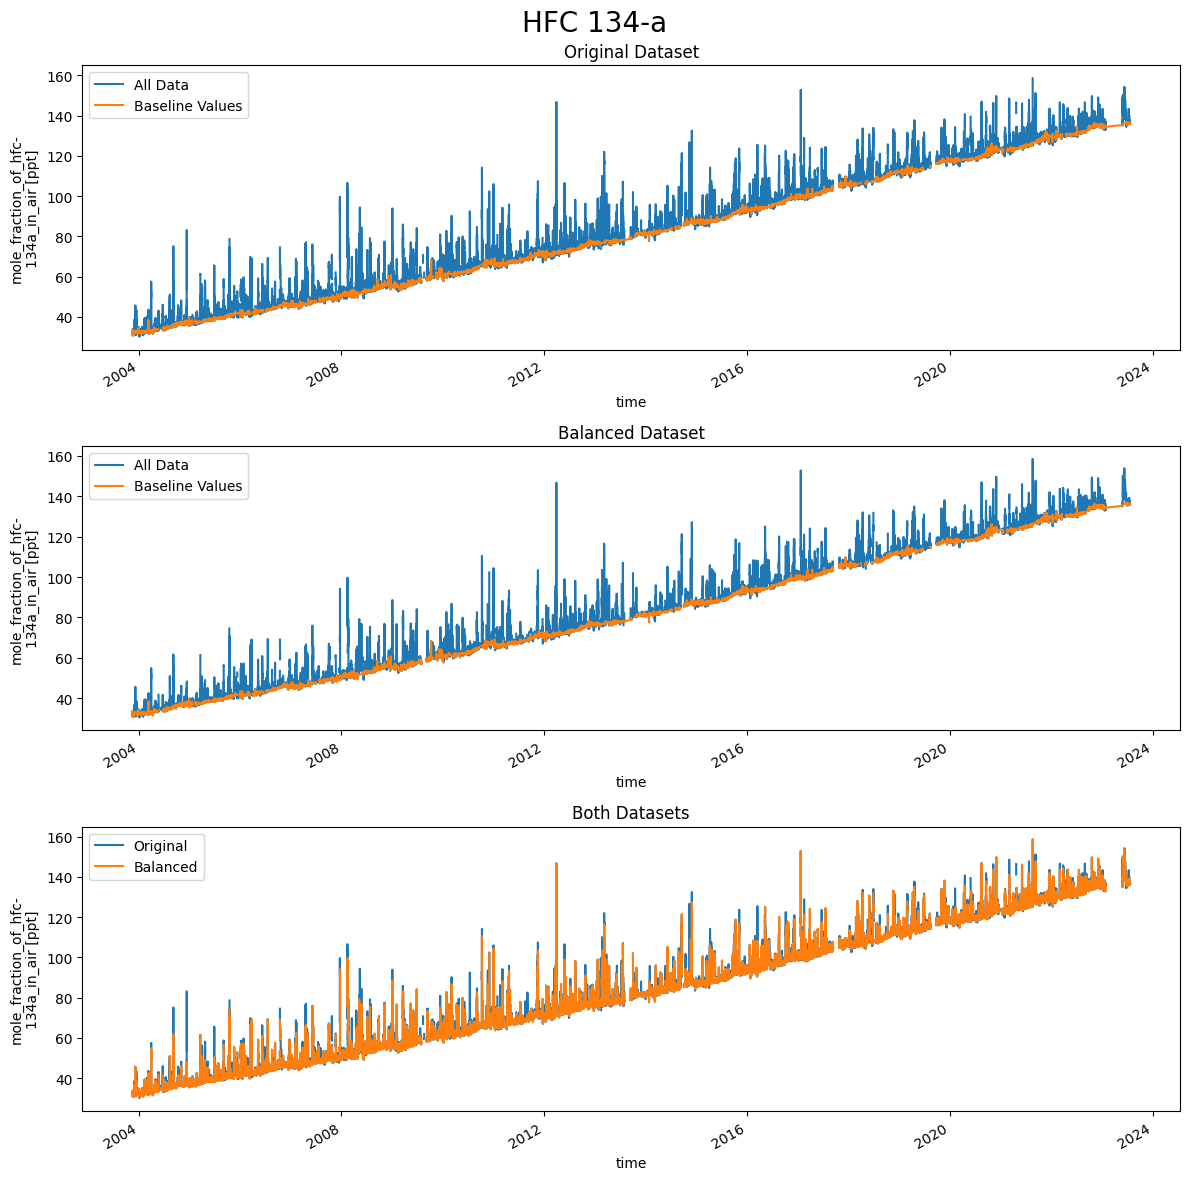

In [15]:
# comparing original and balanced data - no significant data loss
# can I quantify this further?
fig, axs = plt.subplots(3,1, figsize=(12,12))

ds_uvf.mf.plot(ax=axs[0], label="All Data")
ds_uvf.where(ds_uvf.baseline == 1, drop=True).mf.plot(ax=axs[0], label="Baseline Values")
axs[0].set_title("Original Dataset")
axs[0].legend()

ds_uvf_balanced.mf.plot(ax=axs[1], label="All Data")
ds_uvf.where(ds_uvf_balanced.baseline == 1, drop=True).mf.plot(ax=axs[1], label="Baseline Values")
axs[1].set_title("Balanced Dataset")
axs[1].legend()

ds_uvf.mf.plot(ax=axs[2], label="Original")
ds_uvf_balanced.mf.plot(ax=axs[2], label="Balanced")
axs[2].set_title("Both Datasets")
axs[2].legend()

fig.suptitle("HFC 134-a", fontsize=20)
fig.set_tight_layout(True)

In [16]:
# Convert to a pandas dataframe
df_uvf_balanced = pd.DataFrame({"flag": ds_uvf_balanced.baseline.values},
                      index=ds_uvf_balanced.time.values)

for point in ds_uvf_balanced.points.values:
    df_uvf_balanced[f"u_{point}"] = ds_uvf_balanced.uwnd.sel(points=point).values
    df_uvf_balanced[f"v_{point}"] = ds_uvf_balanced.vwnd.sel(points=point).values

# Include time of day as another feature (probably doesn't help, but you never know)
df_uvf_balanced["time_of_day"] = df_uvf_balanced.index.hour

In [59]:
# Save to a CSV file
df_uvf_balanced.index.name = 'time'
df_uvf_balanced.to_csv('/Users/kirst/Downloads/uvf.csv', index=True)

Now train model using the training notebook, and then load best model below

In [ ]:
# Load model
rf_model = load('/Users/kirst/Downloads/rf_model.joblib')

In [ ]:
# Predict baseline values
df_predict = df_uvf.copy()
df_predict.drop(columns=["flag"], inplace=True)
df_uvf["predicted_flag"] = rf_model.predict(df_predict.reset_index(drop=True))

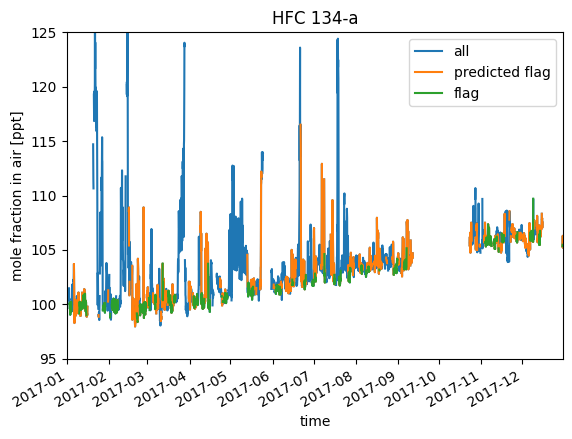

In [ ]:
# Plot the results
df_plot = df_uvf.copy()
df_plot["mf"] = ds_uvf.mf.values

df_plot["mf"].plot(label="all")
df_plot["mf"].where(df_plot["predicted_flag"] == 1).plot(label="predicted flag")
df_plot["mf"].where(df_plot["flag"] == 1).plot(label="flag")

plt.xlim(datetime.datetime(2017, 1, 1), datetime.datetime(2017, 12, 31))
plt.ylim(95, 125)
plt.ylabel("mole fraction in air [ppt]")
plt.title("HFC 134-a")
plt.legend()